Copyright (C) Egon Kidmose 2015-2018

This file is part of lstm-rnn-correlation.

lstm-rnn-correlation is free software: you can redistribute it and/or
modify it under the terms of the GNU Lesser General Public License as
published by the Free Software Foundation, either version 3 of the
License, or (at your option) any later version.

lstm-rnn-correlation is distributed in the hope that it will be
useful, but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public
License along with lstm-rnn-correlation. If not, see
<http://www.gnu.org/licenses/>.

# Label alerts with incident description

 1. Loads alerts
 2. Load incident descriptions
 3. Label alerts according incident descriptions, default to benign
 4. Plot/analyse for validation

In [1]:
from lstm_rnn_tied_weights import util
from lstm_rnn_tied_weights import snort

import glob
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import cPickle as pickle
from distutils.version import LooseVersion
from functools import partial

# matplotlib
try: # might, might not have x available
    import os
    os.environ['DISPLAY']
except KeyError:
    import matplotlib
    matplotlib.use('Agg')
try: # might, might not be notebook
    %matplotlib inline
except NameError:
    pass
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import dask.dataframe as ddf
from dask.multiprocessing import get as dget

/home/egk/git-reps/lstm-rnn-correlation/venv/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
logger = util.get_logger('preprocessing-cic-ids-2017')

output_prefix = os.path.join('output', 'preprocessing-'+util.get_runid(), util.get_runid()+'-')
if not os.path.exists('output'):
    os.mkdir('output')
if not os.path.exists(os.path.dirname(output_prefix)):
    os.mkdir(os.path.dirname(output_prefix))

seed = 1531857839 # Unix time at time of writing
def rndseed():
    global seed
    seed += 1
    return seed

Output prefix: log/preprocessing-cic-ids-2017-20180719-112552-egk-aau-laptop/20180719-112552-egk-aau-laptop-


## Load alerts

In [3]:
# importing data
alertfiles = glob.glob('../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/*.pcap.out')
alerts = None

for fn in sorted(alertfiles):
    logger.debug('Loading %s' % fn)
    with open(fn) as f:
        df = pd.DataFrame(f.readlines(),columns=['line'])
        df = df.join(pd.DataFrame(
            map(snort.parse_line, df.line),
            columns=['ts', 'rid', 'msg', 'prio', 'proto', 'srcip', 'srcport', 'dstip', 'dstport'],
        ))
    alerts = pd.concat([alerts, df])
    logger.info("Loaded %d alerts from %s" % (len(df), fn,))

logger.info("All data loaded, %d total alerts" % len(alerts))

Loaded 61491 alerts from ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/Friday-WorkingHours.pcap.out
Loaded 46530 alerts from ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/Monday-WorkingHours.pcap.out
Loaded 30237 alerts from ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/Thursday-WorkingHours.pcap.out
Loaded 34580 alerts from ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/Tuesday-WorkingHours.pcap.out
Loaded 259022 alerts from ../../data/iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/snort/Wednesday-workingHours.pcap.out
All data loaded, 431860 total alerts


In [4]:
# Snort truncates year and is off by 3 hours, fix:
alerts.ts = alerts.ts + (datetime(2017, 1, 1) - datetime(1900, 1, 1)) # increment year to 2017
alerts.ts = alerts.ts - pd.to_timedelta('3h') # Add three hours to move alerts to 9:00-17:00. Dunno why. Maybe tz in snort...
alerts = alerts.sort_values('ts').reset_index(drop=True)

## Load incident descriptions

In [5]:
# load incident descriptions, extracted from website text
inc_desc = pd.read_csv(
    'incident_descriptions.csv', 
    parse_dates=['Start', 'Stop'],
    date_parser = lambda x: pd.datetime.strptime(x, '%d-%m-%y %H:%M')
)
inc_desc['Stop'] = inc_desc['Stop'].dt.floor('min') + timedelta(minutes=1)
inc_desc['Interval'] = inc_desc[['Start', 'Stop',]].apply(
    lambda d: pd.Interval(d[0], d[1], closed='both'), 
    axis=1
)


## Label alerts with incident descriptions

In [6]:
# For each alert, get a label
# if an ip match and alert.ts is within description: use label
# default to benign
# don't use IP's of firewall, because it does the NATin
def get_label(alert):
    # Find incident description where time matches
    idx_time = inc_desc.Interval.apply(lambda iv: alert.ts in iv)
    
    # Find  incident description where at least one IP matches:
    ignored_ips = {
        '205.174.165.80', # External IP of firewall (NATing)
        '172.16.0.1', # Internal IP of firewall (NATing)
    }
    idx_ip = pd.Series(np.zeros(inc_desc.shape[0], dtype=bool), index=inc_desc.index)
    if alert.srcip not in ignored_ips:
        idx_ip = idx_ip | (alert.srcip == inc_desc['IP attacker']) | (alert.srcip == inc_desc['IP victim'])
    if alert.dstip not in ignored_ips:
        idx_ip = idx_ip | (alert.dstip == inc_desc['IP attacker']) | (alert.dstip == inc_desc['IP victim'])
    
    idx = idx_time & idx_ip
    # No hits then default to benign
    if not idx.any():
        return 'BENIGN'
    
    res = inc_desc[idx].Label.unique() # Don't care about multiple hits for same label
    assert res.shape[0] == 1, "Multiple lables match the same alert"
    # ... pd.Dataframe.apply does not handle multiple values well, so not supported here
    # ... see https://github.com/pandas-dev/pandas/issues/15628
    return res[0]

In [7]:
# apply get_label in parallel using dask
# takes about 10 minutes on 4 cores
dalerts = ddf.from_pandas(alerts, npartitions=4*3-1)
alerts['Label'] = dalerts.map_partitions(
    lambda df: df.apply(get_label, axis=1)
).compute(get=dget)

/home/egk/git-reps/lstm-rnn-correlation/venv/local/lib/python2.7/site-packages/dask/base.py:835: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "


## Analyse

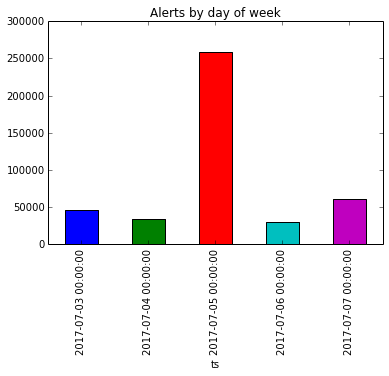

In [8]:
alerts.groupby([alerts.ts.dt.floor('d')]).count().ts.plot(kind="bar")
plt.title('Alerts by day of week')

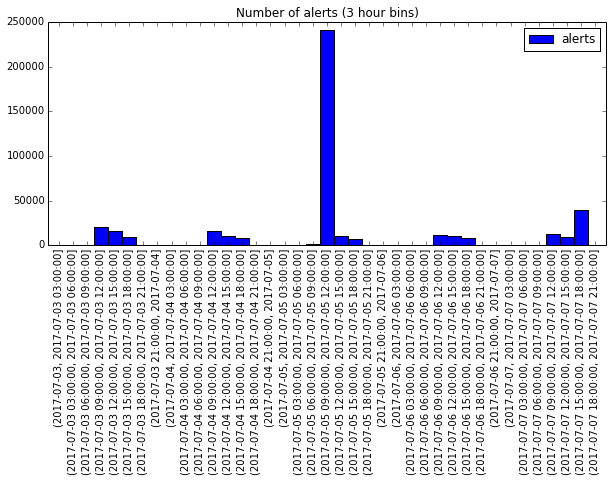

In [9]:
pd.DataFrame(
    pd.cut(
        alerts.ts, bins=pd.date_range('2017-07-03', freq='3H', periods=40)
    ).value_counts().rename('alerts').sort_index(),
).plot(kind='bar', width=1, figsize=(10,4))
plt.title('Number of alerts (3 hour bins)')

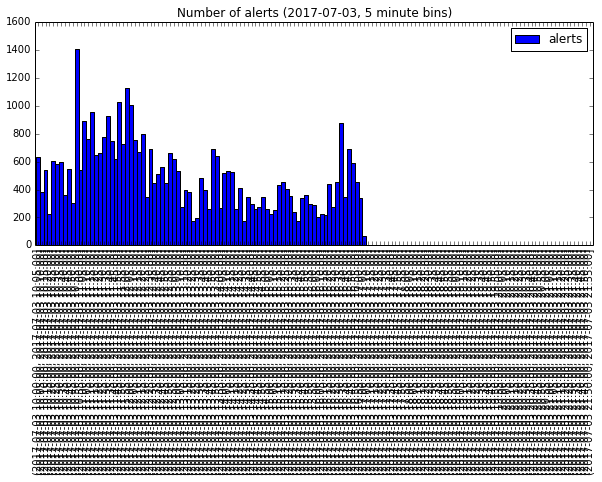

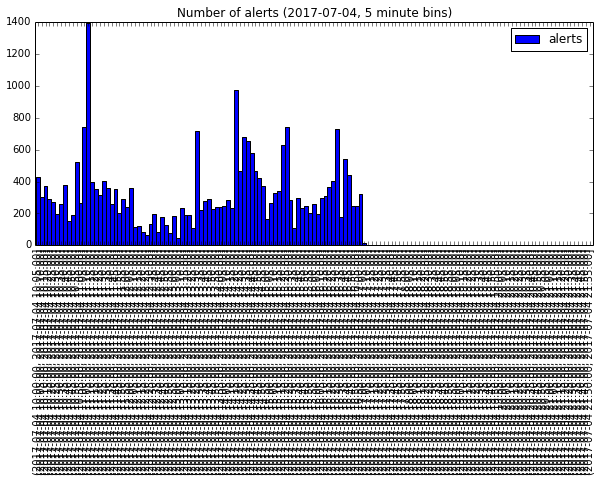

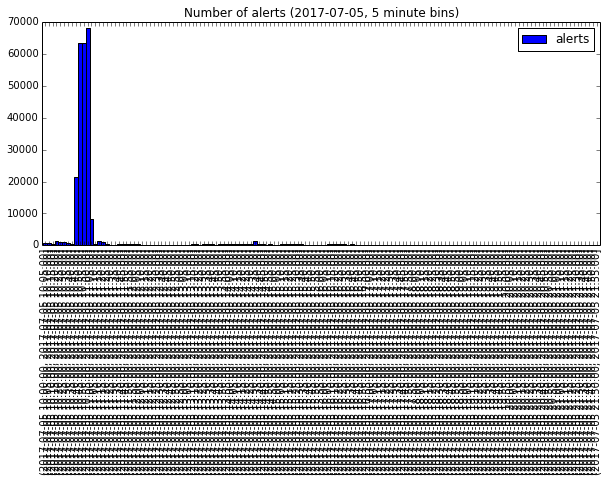

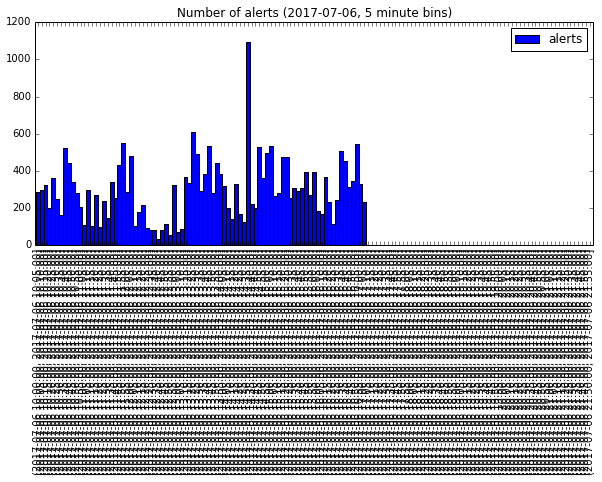

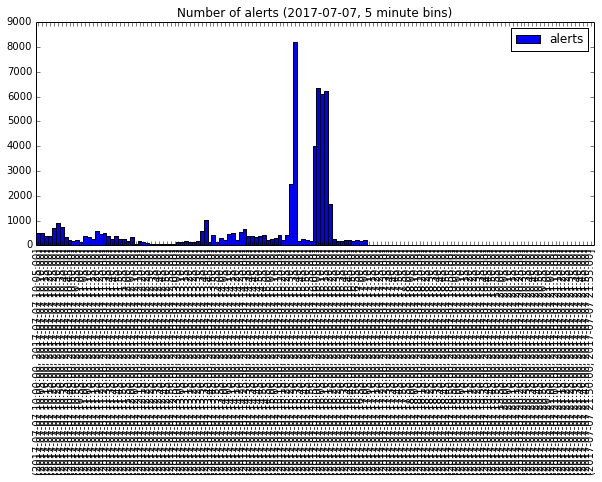

In [10]:
for day in range(5):
    start = '2017-07-%.2d' % (day + 3)
    pd.DataFrame(
        pd.cut(
            alerts.ts, bins=pd.date_range(start + ' 10:00', freq='300s', periods=0.5*24*60./5)
        ).value_counts().rename('alerts').sort_index(),
    ).plot(kind='bar', width=1, figsize=(10,4))
    plt.title('Number of alerts (%s, 5 minute bins)' % start)

/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)


/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:452: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)


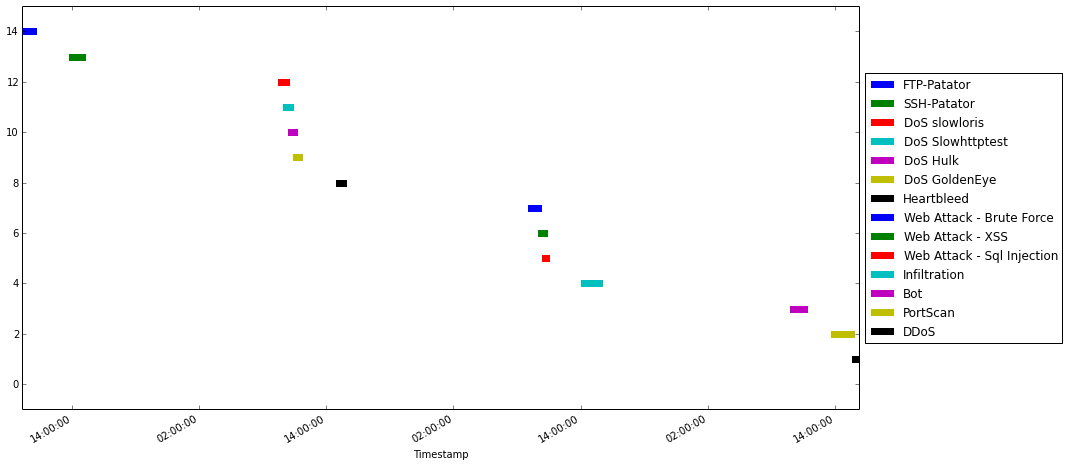

In [11]:
# plot description from webpage

# Flat (i.e. start and stop in same column)
inc_desc_flat = pd.concat([
    inc_desc.rename(columns={'Start': 'Timestamp'}),
    inc_desc.rename(columns={'Stop': 'Timestamp'}),
])

begin = inc_desc_flat.groupby('Label').Timestamp.min().sort_values()
end =  inc_desc_flat.groupby('Label').Timestamp.max()

# create an index containing all min and max timestamps
df_periods = pd.DataFrame(index=pd.Index(pd.concat([begin, end,])))

# create a (constant) Series for each series
for idx, d in enumerate(begin.index):
    df_periods[d] = df_periods.index.to_series().apply(
        lambda x: begin.shape[0] - idx if x >= begin[d] and x <= end[d] else np.NaN
    )

ax = df_periods.plot(
    ylim=[-1, begin.shape[0]+1],
    xlim=[begin.min(), end.max()],
    linewidth=7,
    legend=True,
    figsize=(15, 8),
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


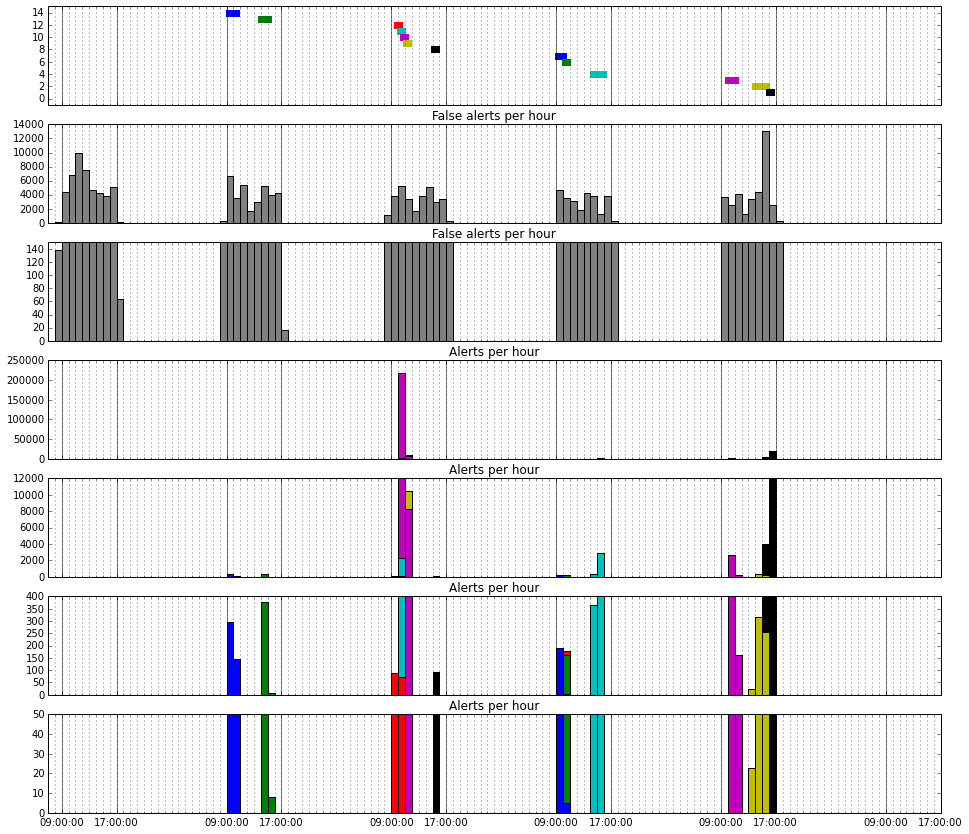

In [12]:
# A hell of a lot of plotting, by time

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

fig, axes = plt.subplots(
    nrows=7, 
    figsize=(16, 16),
    sharex=True,
)

# plot description from webpage

# Flat (i.e. start and stop in same column)
inc_desc_flat = pd.concat([
    inc_desc.rename(columns={'Start': 'Timestamp'}),
    inc_desc.rename(columns={'Stop': 'Timestamp'}),
])

begin = inc_desc_flat.groupby('Label').Timestamp.min().sort_values()
end =  inc_desc_flat.groupby('Label').Timestamp.max()

# create an index containing all min and max timestamps
df_periods = pd.DataFrame(index=pd.Index(pd.concat([begin, end,])))

# create a (constant) Series for each series
for idx, d in enumerate(begin.index):
    df_periods[d] = df_periods.index.to_series().apply(
        lambda x: begin.shape[0] - idx if x >= begin[d] and x <= end[d] else np.NaN
    )

df_periods.plot(
    ylim=[-1, begin.shape[0]+1],
    xlim=[begin.min(), end.max()],
    linewidth=7,
    ax=axes[0],
    legend=False,
)

# Store colors for reuse
colors = {line.get_label(): line.get_color() for line in axes[0].lines}
colors['BENIGN'] = '#808080' # Benign is not in rules..

# False alert timestamps binned
alert_bins = alerts[alerts.Label == 'BENIGN'].reset_index().set_index('ts').resample('1H').count()['index'].rename('alerts')
ax = axes[1].bar(
    alert_bins.index,
    alert_bins,
    color=colors['BENIGN'],
    width=1./24, # x axis is float of days
)
axes[1].set_title('False alerts per hour')

# False alert timestamps binned - short y axis
alert_bins = alerts[alerts.Label == 'BENIGN'].reset_index().set_index('ts').resample('1H').count()['index'].rename('alerts')
ax = axes[2].bar(
    alert_bins.index,
    alert_bins,
    color=colors['BENIGN'],
    width=1./24, # x axis is float of days
)
axes[2].set_title('False alerts per hour')
axes[2].set_ylim((0, 150))

# Alert timestamps binned - By label
alert_bins = pd.DataFrame([
    alerts[alerts.Label == desc].reset_index().set_index('ts').resample('1H').count()['index'].rename(desc)
    for desc in alerts.Label.unique() if 'BENIGN' not in desc
])

for ii, desc in enumerate(alert_bins.index):
    axes[3].bar(
        alert_bins.columns,
        alert_bins.fillna(0).iloc[ii,:],
        bottom=alert_bins.fillna(0).cumsum().iloc[ii,:]-alert_bins.fillna(0).iloc[ii,:],
        width=1./24, # x axis is float of days
        label=desc,
        color=colors[desc],
    )
axes[3].set_title('Alerts per hour')

# Alert timestamps binned - By label - short y axis
for ii, desc in enumerate(alert_bins.index):
    axes[4].bar(
        alert_bins.columns,
        alert_bins.fillna(0).iloc[ii,:],
        bottom=alert_bins.fillna(0).cumsum().iloc[ii,:]-alert_bins.fillna(0).iloc[ii,:],
        width=1./24, # x axis is float of days
        label=desc,
        color=colors[desc],
    )
axes[4].set_title('Alerts per hour')
axes[4].set_ylim((0, 12000))

# Alert timestamps binned - By label - shortER y axis
for ii, desc in enumerate(alert_bins.index):
    axes[5].bar(
        alert_bins.columns,
        alert_bins.fillna(0).iloc[ii,:],
        bottom=alert_bins.fillna(0).cumsum().iloc[ii,:]-alert_bins.fillna(0).iloc[ii,:],
        width=1./24, # x axis is float of days
        label=desc,
        color=colors[desc],
    )
axes[5].set_title('Alerts per hour')
axes[5].set_ylim((0, 400))

# Alert timestamps binned - By label - EVEN shortER y axis
for ii, desc in enumerate(alert_bins.index):
    axes[6].bar(
        alert_bins.columns,
        alert_bins.fillna(0).iloc[ii,:],
        bottom=alert_bins.fillna(0).cumsum().iloc[ii,:]-alert_bins.fillna(0).iloc[ii,:],
        width=1./24, # x axis is float of days
        label=desc,
        color=colors[desc],
    )
axes[6].set_title('Alerts per hour')
axes[6].set_ylim((0, 50))

# General
for ax in axes:
    ax.grid(axis='x', which='minor')
    ax.grid(axis='x', which='major', linestyle='-')

ax = axes[5]
plt.sca(ax)

ax.xaxis.set_minor_locator(mdates.HourLocator())
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[9, 17]))

datemin = pd.to_datetime('07-03-2017 7:00')
datemax = pd.to_datetime('07-08-2017 17:00')
ax.set_xlim(datemin, datemax)

plt.xticks(rotation=90)
None

In [13]:
def get_data_overview(data):
    df_inc_cnt = pd.DataFrame(data.groupby(['Label']).size().rename('inc_cnt').reset_index())
    df_inc_cnt['inc_cnt_pct'] = df_inc_cnt['inc_cnt']/data.count()[0]*100

    df_inc_prio_cnt = pd.DataFrame(
        pd.merge(data, df_inc_cnt, on='Label').groupby(['Label', 'prio', 'inc_cnt']
    ).size().rename('inc_prio_cnt').reset_index())
    df_inc_prio_cnt['inc_prio_cnt_pct'] = df_inc_prio_cnt['inc_prio_cnt']/df_inc_prio_cnt['inc_cnt']*100

    df_overview = pd.merge(df_inc_cnt, df_inc_prio_cnt).groupby(['Label', 'prio']).first().reset_index()

    tot_prio = data.groupby(['prio']).size().rename('inc_prio_cnt')
    df_tot = pd.DataFrame(tot_prio)
    df_tot['inc_prio_cnt_pct'] = df_tot['inc_prio_cnt']/data.count()[0]*100
    df_tot['inc_cnt'] = data.count()[0]
    df_tot['inc_cnt_pct'] = 100
    df_tot['Label'] = 'total'

    df_overview = pd.concat([df_overview.reset_index(), df_tot.reset_index()])\
        .groupby(['Label', 'inc_cnt', 'inc_cnt_pct', 'prio', ])\
        .first().drop('index', 1)

    return df_overview

assert set(
    inc_desc.Label.unique().tolist() + ['BENIGN']
) == set(
    alerts.Label.unique()
), "Some labels are not represented"

logger.info('Overview of labelled data')
df_overview = get_data_overview(alerts)
logger.debug(df_overview.to_latex())
logger.debug(df_overview.to_string())
df_overview

Overview of labelled data


inc_prio_cnt  \
Label                      inc_cnt inc_cnt_pct prio                 
BENIGN                     172447  39.931228   1              105   
                                               2           118425   
                                               3            53917   
Bot                        2812    0.651137    1               54   
                                               2              998   
                                               3             1760   
DDoS                       23111   5.351503    2              156   
                                               3            22955   
DoS GoldenEye              2200    0.509424    2              395   
                                               3             1805   
DoS Hulk                   223760  51.813088   2            98145   
                                               3           125615   
DoS Slowhttptest           2172    0.502941    2             1177   
                                               3              995   
DoS slowloris              162     0.037512    2              151   
                                               3               11   
FTP-Patator                441     0.102116    1                2   
                                               2              439   
Heartbleed                 92      0.021303    2               80   
                                               3               12   
Infiltration               3312    0.766915    1                2   
                                               2             2384   
                                               3              926   
PortScan                   596     0.138008    2              549   
                                               3               47   
SSH-Patator                387     0.089612    2              384   
                                               3                3   
Web Attack - Brute Force   195     0.045154    2              193   
                                               3                2   
Web Attack - Sql Injection 15      0.003473    1               10   
                                               2                5   
Web Attack - XSS           158     0.036586    2              142   
                                               3               16   
total                      431860  100.000000  1              173   
                                               2           223623   
                                               3           208064   

                                                     inc_prio_cnt_pct  
Label                      inc_cnt inc_cnt_pct prio                    
BENIGN                     172447  39.931228   1             0.060888  
                                               2            68.673274  
                                               3            31.265838  
Bot                        2812    0.651137    1             1.920341  
                                               2            35.490754  
                                               3            62.588905  
DDoS                       23111   5.351503    2             0.675003  
                                               3            99.324997  
DoS GoldenEye              2200    0.509424    2            17.954545  
                                               3            82.045455  
DoS Hulk                   223760  51.813088   2            43.861727  
                                               3            56.138273  
DoS Slowhttptest           2172    0.502941    2            54.189687  
                                               3            45.810313  
DoS slowloris              162     0.037512    2            93.209877  
                                               3             6.790123  
FTP-Patator                441     0.102116    1             0.453515  
                                               2            99

In [14]:
# Limit how many alerts we have for each incident
alerts_strat = None

# For the malicous
PER_CLASS_MAX_COUNT = 200

for label in inc_desc.Label.unique():

    idx = alerts.Label == label

    if idx.sum() > PER_CLASS_MAX_COUNT:
        logger.info("More than %d in %s: %d. Limiting to %d." % (
            PER_CLASS_MAX_COUNT,
            label,
            idx.sum(),
            PER_CLASS_MAX_COUNT,
        ))
        np.random.seed(rndseed()) # repeatable random
        idx &= idx.iloc[ # AND with selected
            np.random.permutation( # shuffle
                alerts.index[idx] # indices of where true
            )[:PER_CLASS_MAX_COUNT] # limit 
        ]
    
    alerts_strat = pd.concat([alerts_strat, alerts[idx]])

# For the benign
TARGET_TOTAL = 4316 # From mcfp/private merged data set

idx = alerts.Label == 'BENIGN'

np.random.seed(rndseed()) # repeatable random
idx &= idx.iloc[ # AND with selected
    np.random.permutation( # shuffle
        alerts.index[idx] # indices of where true
    )[:TARGET_TOTAL - alerts_strat.shape[0]] # limit 
]

alerts_strat = pd.concat([alerts_strat, alerts[idx]])

More than 200 in FTP-Patator: 441. Limiting to 200.
More than 200 in SSH-Patator: 387. Limiting to 200.
More than 200 in DoS Slowhttptest: 2172. Limiting to 200.
More than 200 in DoS Hulk: 223760. Limiting to 200.
More than 200 in DoS GoldenEye: 2200. Limiting to 200.
More than 200 in Infiltration: 3312. Limiting to 200.
More than 200 in Bot: 2812. Limiting to 200.
More than 200 in PortScan: 596. Limiting to 200.
More than 200 in DDoS: 23111. Limiting to 200.


In [15]:
counts_before = alerts.groupby('Label').Label.count().rename('Alert count')
counts_after = alerts_strat.groupby('Label').Label.count().rename('Alert count after stratification')

df_strat_effect = pd.concat(
    [counts_before, counts_after],axis=1
).append(
    pd.Series({
        counts_before.name : counts_before.sum(),
        counts_after.name : counts_after.sum()
    }, name='Total')
)

logger.info('Effects of stratifying data:')
logger.debug(df_strat_effect.to_latex())
logger.debug(df_strat_effect.to_string())
df_strat_effect

Effects of stratifying data:


,Alert count,Alert count after stratification
Label,,
BENIGN,172447,1894
Bot,2812,200
DDoS,23111,200
DoS GoldenEye,2200,200
DoS Hulk,223760,200
DoS Slowhttptest,2172,200
DoS slowloris,162,162
FTP-Patator,441,200
Heartbleed,92,92


In [16]:
logger.info('Overview of stratified data')
df_overview_strat = get_data_overview(alerts_strat)
logger.debug(df_overview_strat.to_latex())
logger.debug(df_overview_strat.to_string())
df_overview_strat

Overview of stratified data


inc_prio_cnt  \
Label                      inc_cnt inc_cnt_pct prio                 
BENIGN                     1894    43.883225   1                3   
                                               2             1308   
                                               3              583   
Bot                        200     4.633920    1                2   
                                               2               80   
                                               3              118   
DDoS                       200     4.633920    3              200   
DoS GoldenEye              200     4.633920    2               40   
                                               3              160   
DoS Hulk                   200     4.633920    2               83   
                                               3              117   
DoS Slowhttptest           200     4.633920    2              109   
                                               3               91   
DoS slowloris              162     3.753475    2              151   
                                               3               11   
FTP-Patator                200     4.633920    2              200   
Heartbleed                 92      2.131603    2               80   
                                               3               12   
Infiltration               200     4.633920    2              145   
                                               3               55   
PortScan                   200     4.633920    2              184   
                                               3               16   
SSH-Patator                200     4.633920    2              197   
                                               3                3   
Web Attack - Brute Force   195     4.518072    2              193   
                                               3                2   
Web Attack - Sql Injection 15      0.347544    1               10   
                                               2                5   
Web Attack - XSS           158     3.660797    2              142   
                                               3               16   
total                      4316    100.000000  1               15   
                                               2             2917   
                                               3             1384   

                                                     inc_prio_cnt_pct  
Label                      inc_cnt inc_cnt_pct prio                    
BENIGN                     1894    43.883225   1             0.158395  
                                               2            69.060190  
                                               3            30.781415  
Bot                        200     4.633920    1             1.000000  
                                               2            40.000000  
                                               3            59.000000  
DDoS                       200     4.633920    3           100.000000  
DoS GoldenEye              200     4.633920    2            20.000000  
                                               3            80.000000  
DoS Hulk                   200     4.633920    2            41.500000  
                                               3            58.500000  
DoS Slowhttptest           200     4.633920    2            54.500000  
                                               3            45.500000  
DoS slowloris              162     3.753475    2            93.209877  
                                               3             6.790123  
FTP-Patator                200     4.633920    2           100.000000  
Heartbleed                 92      2.131603    2            86.956522  
                                               3            13.043478  
Infiltration               200     4.633920    2            72.500000  
                                               3            27.500000  
PortScan                   200     4.633920    2     

## Split alerts

In [17]:
logger.info('Splitting data')

# Shuffle
np.random.seed(rndseed())
alerts_strat.reindex(np.random.permutation(alerts_strat.index))

alerts_strat = alerts_strat.reset_index().reset_index().set_index('index')
alerts_strat['cut'] = alerts_strat.level_0 % 10
alerts_strat.drop('level_0', axis=1, inplace=True)

alert_count = pd.DataFrame(alerts_strat.groupby('cut').size().rename('Alert count')).T
logger.info('Alert count by cuts: \n' + alert_count.to_string())
alert_count


Splitting data
Alert count by cuts: 
cut            0    1    2    3    4    5    6    7    8    9
Alert count  432  432  432  432  432  432  431  431  431  431


cut,0,1,2,3,4,5,6,7,8,9
Alert count,432,432,432,432,432,432,431,431,431,431


## Fix format for consumption by lstm-rnn-tied-weights script

In [18]:
data = alerts_strat.rename(columns={'line': 'alert'})
# get mapper from labels to incident IDs
label_mapper = {k: v+1 for v, k in enumerate(
    inc_desc.set_index('Start').sort_index().Label.drop_duplicates()
)}
logger.info("label_mapper = %s" % str(label_mapper))
with open(output_prefix + 'label_mapper.json', 'w') as f:
    json.dump(label_mapper, f)
label_mapper['BENIGN'] = 'benign'
# Map labels to incident IDs*
data['incident'] = data.Label.map(lambda l: label_mapper[l])

## Save alerts

In [19]:
logger.info('Saving alerts')
data.to_csv(
    output_prefix + 'alerts.csv',
    columns=['incident', 'alert', 'cut'],
    index=False,
)
logger.info('Saved alerts')

Saving alerts
Saved alerts


In [20]:
logger.info('Saving test alerts')
data_test = pd.DataFrame()
for (i, c) in [(i, c) for i in data['incident'].unique() for c in data['cut'].unique()]:
    data_test = pd.concat([
        data_test,
        data[(data['incident'] == i) & (data['cut'] == c)].head(100)
    ])
data_test.to_csv(
    output_prefix + 'alerts.csv.test',
    columns=['incident', 'alert', 'cut'],
    index=False,
)
logger.info('Saved test alerts')

Saving test alerts
Saved test alerts


In [21]:
logger.info('Completed')

Completed
